# KL Dra

In [1]:
import json
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
from lightkurve.lightcurve import LightCurve as LC
from lightkurve import TessTargetPixelFile

import eleanor

from bokeh.plotting import output_notebook, figure, show
from bokeh.models import HoverTool, tools,ColumnDataSource, Whisker, ColorBar, LinearColorMapper
output_notebook()

from bokeh.models.callbacks import CustomJS
from bokehfun import *

Loading BokehJS ...

In [2]:
with open('response.json','r') as JSON:
    rdic = json.load(JSON)
name = 'SDSSJ1908+3940'
star = rdic[name]

In [3]:
star['ra']
starcoord = "{} +{}".format(star['ra'],star['dec'])
print(starcoord)

287.071125 +39.67677777777777


In [4]:
lk.search_tesscut(starcoord)

#,observation,target_name,productFilename,distance
0,TESS Sector 14,287.071125 +39.67677777777777,TESSCut,0.0


In [5]:
tpf = lk.search_tesscut(starcoord,sector=14).download(cutout_size=11)

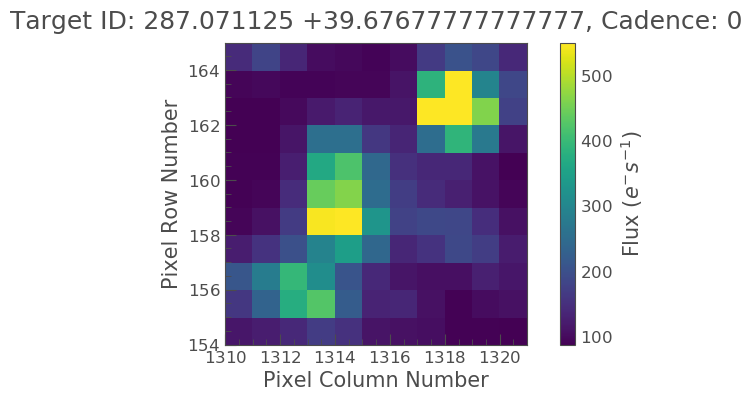

In [6]:
tpf.plot()

# With the help of Bokeh can select a region and get the indices to plot. Needs imporvement

In [53]:
def update_upon_pixel_selection(attr, old, new):
    """Callback to take action when pixels are selected."""
    # Check if a selection was "re-clicked", then de-select
    if ((sorted(old) == sorted(new)) & (new != [])):
        # Trigger recursion
        tpf_source.selected.indices = new[1:]
        
tpf_source.selected.on_change('indices', update_upon_pixel_selection)

In [54]:
npix = tpf.flux[0, :, :].size
pixel_index_array = np.arange(0, npix, 1).reshape(tpf.flux[0].shape)

aperture_mask = np.zeros(tpf.shape[1:], dtype=np.int)
tpf_source = prepare_tpf_datasource(tpf, aperture_mask)

# Create the TPF figure and its stretch slider
pedestal = -np.nanmin(tpf.flux) + 1
fig_tpf, stretch_slider = make_tpf_figure_elements(tpf, tpf_source,
                                                   pedestal=pedestal,
                                                   fiducial_frame=0)


show(fig_tpf)

# From the alert get the index and plot:

In [57]:
backgroundname = 'background'
tpf.interact(exported_filename='backgroundname')

In [ ]:
a = 

11


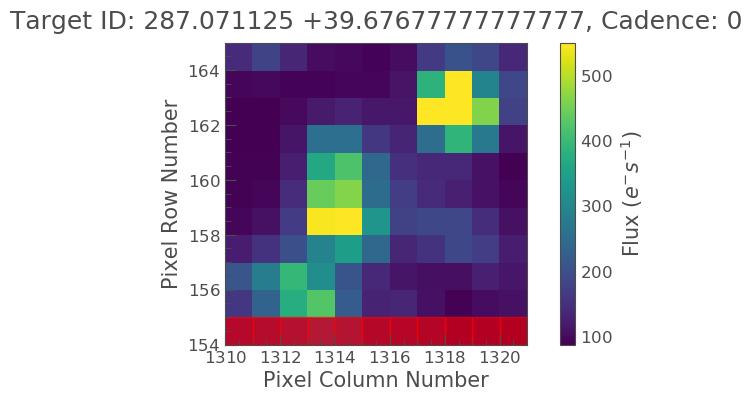

In [25]:
indexalert = [96]
indexalert = tpf_source.selected.indices
selected_indices = np.array(indexalert)
aper = np.isin(pixel_index_array, selected_indices)
#aper = np.zeros(tpf.shape[1:], dtype=np.int)
#aper[5:6, 5:6] = 1 #
#aper[4:6, 5] = 1
#aper[5, 5] = 1 #y luego x


tpf.plot(aperture_mask=aper, mask_color='red');
n_target_pixels = aper.sum()
print(n_target_pixels)

## Create a light-curve

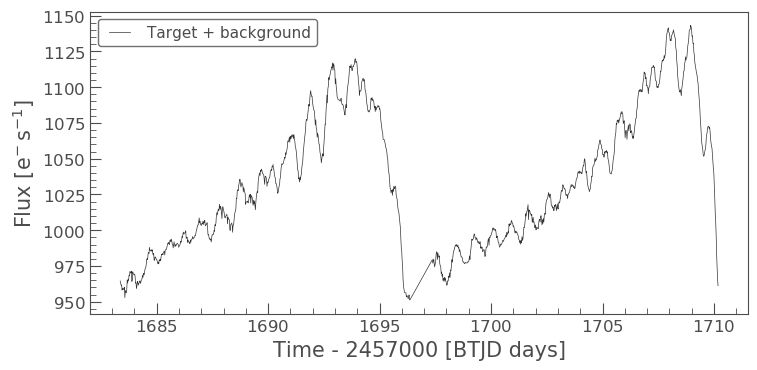

In [39]:
target_lc = tpf.to_lightcurve(aperture_mask=aper.astype(bool))
target_lc.plot(label='Target + background');

61


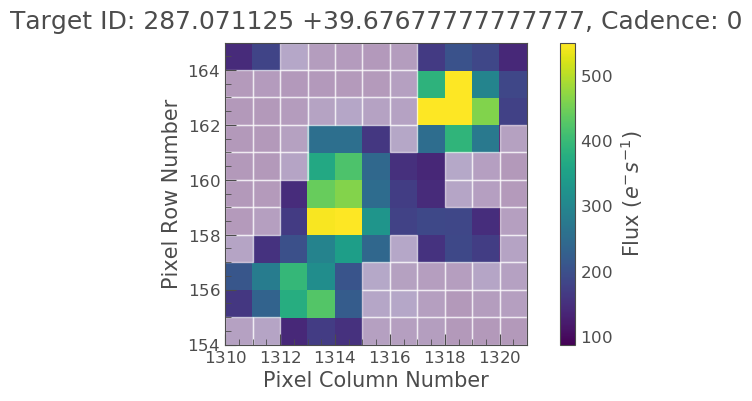

In [48]:
background_mask = ~tpf.create_threshold_mask(threshold=0.00001, reference_pixel=None)
tpf.plot(aperture_mask=background_mask, mask_color='w');
n_background_pixels = background_mask.sum()
print(n_background_pixels)

In [13]:
tpf.interact_sky()

# Or select background manually


In [41]:
npix = tpf.flux[0, :, :].size
pixel_index_array = np.arange(0, npix, 1).reshape(tpf.flux[0].shape)


tpf_source = prepare_tpf_datasource(tpf, aperture_mask)

# Create the TPF figure and its stretch slider
pedestal = -np.nanmin(tpf.flux) + 1
fig_tpf, stretch_slider = make_tpf_figure_elements(tpf, tpf_source,
                                                   pedestal=pedestal,
                                                   fiducial_frame=0)
tpf_source.selected.js_on_change(
    "indices",
    CustomJS(
        args=dict(s1=tpf_source),
        code="""
        var inds = cb_obj.indices;
        var d1 = s1.data;
        window.alert(inds)
    """,
    ),
)

show(fig_tpf)

In [42]:
indexalertback = [76,65]

selected_indices_back = np.array(indexalertback)
background_mask = np.isin(pixel_index_array, selected_indices_back)

## The amount of background seen in the target aperture is the background flux per pixel times the number of pixels in the target aperture.



In [49]:
background_lc_per_pixel = tpf.to_lightcurve(aperture_mask=background_mask) / n_background_pixels
background_estimate_lc = background_lc_per_pixel * n_target_pixels

## nanpercentile 

Compute the qth percentile of the data along the specified axis, while ignoring nan values.

The second number is the percentile to compute, which must be between 0 and 100 inclusive.

If q is a single percentile and axis=None, then the result is a scalar.


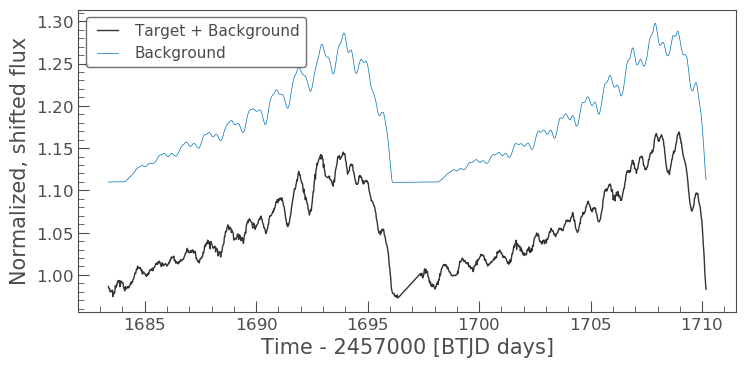

In [50]:


common_normalization = np.nanpercentile(target_lc.flux, 10)
ax = (target_lc / common_normalization).plot(normalize=False, label='Target + Background', lw=1);
(background_estimate_lc / common_normalization +1.).plot(ax=ax, normalize=False, label='Background',
                                                        ylabel='Normalized, shifted flux');



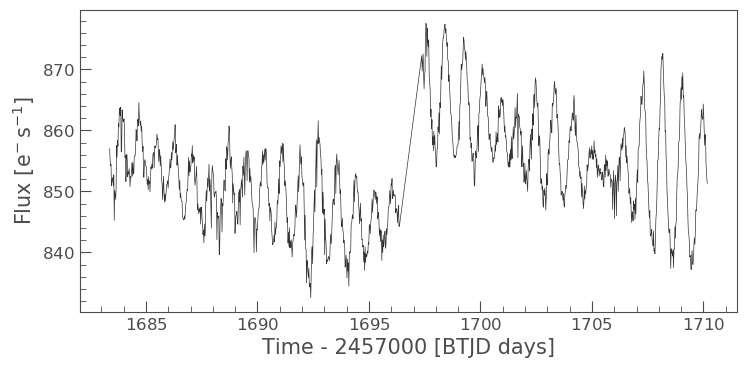

In [51]:
corrected_lc = target_lc - background_estimate_lc.flux
corrected_lc.plot();

# Removes the low frequency trend using scipy’s Savitzky-Golay filter.

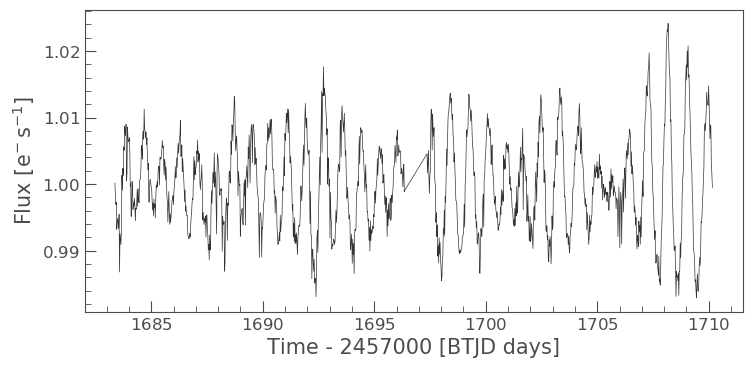

In [52]:
flat_lc = corrected_lc.flatten(window_length=401)
flat_lc.plot();



In [20]:
lcdic = {'time':flat_lc.time,
        "flatflux":flat_lc.flux}
source = ColumnDataSource(data=lcdic)

p = figure(plot_width=900, plot_height=500)
    

#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ('Date', '(@time{0,0.000})')
        ]
    )


p.add_tools(hover2)

p.line('time','flatflux',source=source)
show(p)

# Sector 14 with Eleanor

In [22]:
star = eleanor.Source(coords=(star['ra'],star['dec']), sector=14, tc=True)
data = eleanor.TargetData(star,height=11, width=11)

Inflating...


/home/mmarcano/anaconda3/envs/ele/lib/python3.7/site-packages/eleanor/targetdata.py:383: UserWarning: WARNING: Making a TPF smaller than (9,9) may provide inadequate results.
  warnings.warn('WARNING: Making a TPF smaller than (9,9) may provide inadequate results.')
/home/mmarcano/anaconda3/envs/ele/lib/python3.7/site-packages/eleanor/targetdata.py:393: UserWarning: WARNING: Making a TPF smaller than (9,9) may provide inadequate results.
  warnings.warn('WARNING: Making a TPF smaller than (9,9) may provide inadequate results.')


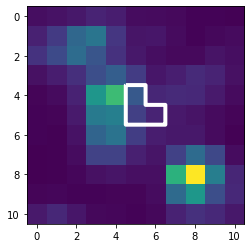

In [23]:
vis = eleanor.Visualize(data)
vis.aperture_contour()

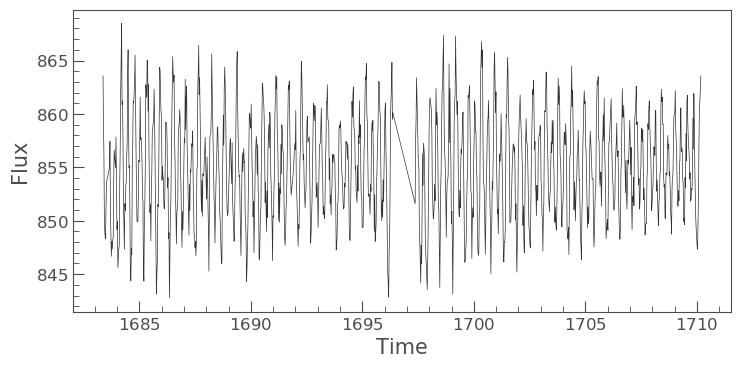

In [24]:
q = data.quality == 0
lk = LC(data.time[q], data.corr_flux[q]).plot()